In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

In [3]:
evt_id=250

910
Event 250, timestamp 0.
Contains 370 traces.


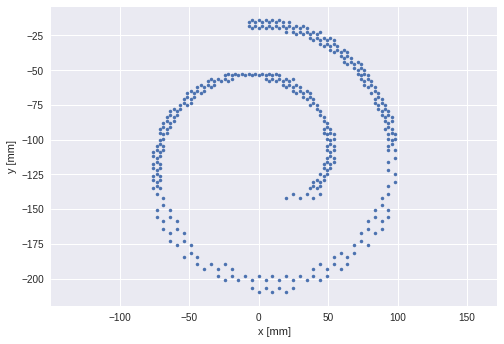

In [4]:
with pytpc.HDFDataFile('/home/taylor/Documents/independent-research/event-gen/data/ptrain_10000.h5','r') as f:
    print(len(f))
    #specific event
    evt = f[evt_id]
    print(evt)
    #trace data from the event
    t = evt.traces

    new_xyz = evt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
    plt.plot(new_xyz[:,0], new_xyz[:,1], '.')
    plt.axis('equal')
        
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    
    #plt.savefig('/home/taylor/Documents/independent-research/event-gen/plots/evtxy_p.pdf')

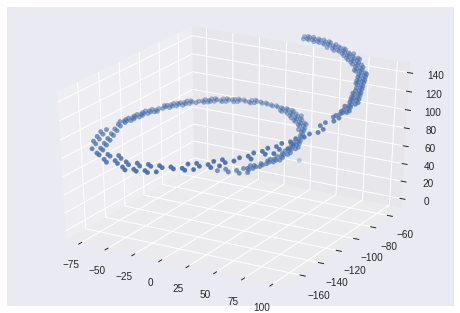

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
with pytpc.HDFDataFile('/home/taylor/Documents/independent-research/event-gen/data/ptrain_10000.h5', 'r') as f:
    n_evts = len(f)
    evt = f[evt_id]
    t = evt.traces['data']
    new_xyz = evt.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
    ax.scatter(new_xyz[:,0], new_xyz[:,1],new_xyz[:,2])
    ax.axis('equal')

In [6]:
DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

In [7]:
#Discretization vars (Integers)
z_disc = 75
radial_disc = 6
angular_disc = 40

print("These values will downsample the xyz scattering data into " + str(z_disc*radial_disc*angular_disc) + " sections/features")

These values will downsample the xyz scattering data into 18000 sections/features


In [8]:
z_inc = DETECTOR_LENGTH/z_disc
angular_inc = (2*math.pi)/angular_disc

z_slices = np.arange(DETECTOR_LENGTH, 0.0-z_inc, -z_inc)
angular_slices = np.arange(-math.pi, math.pi+angular_inc, angular_inc)

In [9]:
radial_slices = np.zeros(radial_disc + 1)

for i in range(len(radial_slices)):
    radial_slices[i] = DETECTOR_RADIUS*math.sqrt((radial_disc-i)/radial_disc)

In [10]:
#checking for equal areas
for i in range(len(radial_slices)-1):
    print("Area of chunk " + str(i) + " = " + str(math.pi*(radial_slices[i]**2-radial_slices[i+1]**2)))

Area of chunk 0 = 39597.1574046
Area of chunk 1 = 39597.1574046
Area of chunk 2 = 39597.1574046
Area of chunk 3 = 39597.1574046
Area of chunk 4 = 39597.1574046
Area of chunk 5 = 39597.1574046


In [11]:
print(z_slices)
print(radial_slices)
print(angular_slices)

[  1.00000000e+03   9.86666667e+02   9.73333333e+02   9.60000000e+02
   9.46666667e+02   9.33333333e+02   9.20000000e+02   9.06666667e+02
   8.93333333e+02   8.80000000e+02   8.66666667e+02   8.53333333e+02
   8.40000000e+02   8.26666667e+02   8.13333333e+02   8.00000000e+02
   7.86666667e+02   7.73333333e+02   7.60000000e+02   7.46666667e+02
   7.33333333e+02   7.20000000e+02   7.06666667e+02   6.93333333e+02
   6.80000000e+02   6.66666667e+02   6.53333333e+02   6.40000000e+02
   6.26666667e+02   6.13333333e+02   6.00000000e+02   5.86666667e+02
   5.73333333e+02   5.60000000e+02   5.46666667e+02   5.33333333e+02
   5.20000000e+02   5.06666667e+02   4.93333333e+02   4.80000000e+02
   4.66666667e+02   4.53333333e+02   4.40000000e+02   4.26666667e+02
   4.13333333e+02   4.00000000e+02   3.86666667e+02   3.73333333e+02
   3.60000000e+02   3.46666667e+02   3.33333333e+02   3.20000000e+02
   3.06666667e+02   2.93333333e+02   2.80000000e+02   2.66666667e+02
   2.53333333e+02   2.40000000e+02

In [12]:
with pytpc.HDFDataFile('/home/taylor/Documents/independent-research/event-gen/data/ptrain_10000.h5', 'r') as f:
    n_evts = len(f)
    evt = f[evt_id]
    t = evt.traces['data']
    new_xyz = evt.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)

In [13]:
discretized_data = np.zeros((1,z_disc*radial_disc*angular_disc))
discretized_xyz = np.zeros([new_xyz.shape[0],new_xyz.shape[1]])

bucket_num = 0
num_pts = 0

for i in range(len(z_slices)-1):
    for j in range(len(radial_slices)-1):
        for k in range(len(angular_slices)-1):
            for point in new_xyz:
                if ((z_slices[i] > point[2] > z_slices[i+1]) and 
                    (radial_slices[j] > math.sqrt(point[0]**2+ point[1]**2) > radial_slices[j+1]) and 
                    (angular_slices[k] < math.atan2(point[1], point[0])  < angular_slices[k+1])):
                    
                    discretized_data[0][bucket_num] = 1
                    num_pts += 1
                    
                    #reassigning xyz values based on bucket
                    avg_z = (z_slices[i]+z_slices[i+1])/2.0
                    avg_r = (radial_slices[j] + radial_slices[j+1])/2.0
                    avg_theta = (angular_slices[k] + angular_slices[k+1])/2.0
                    
                    discretized_xyz[num_pts] = [avg_r*math.cos(avg_theta), avg_r*math.sin(avg_theta), avg_z, point[3], point[4]]

            bucket_num += 1         
            
print(bucket_num)
print("points found: " + str(num_pts) + "   ||   points in data: " + str(len(new_xyz)))
print("buckets filled: " + str(discretized_data.sum()))

18000
points found: 369   ||   points in data: 370
buckets filled: 48.0


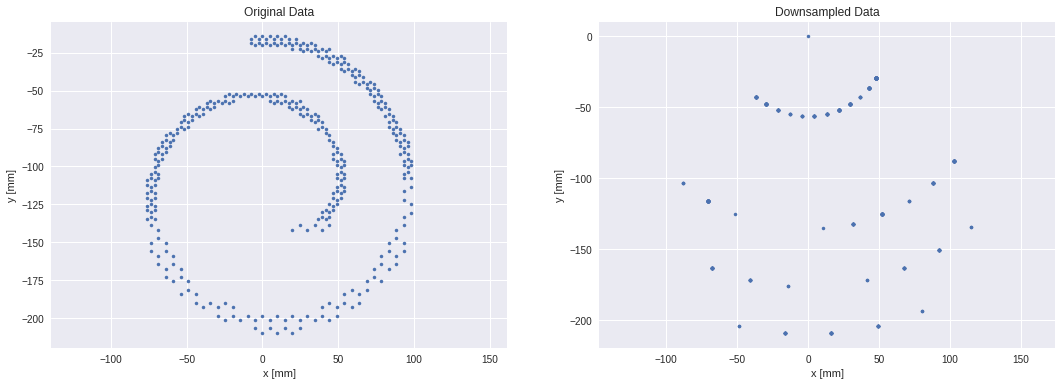

In [14]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 6))

ax[0].plot(new_xyz[:,0], new_xyz[:,1], '.')
ax[0].axis('equal')
        
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[0].set_title('Original Data')

####################################################################################################################
ax[1].plot(discretized_xyz[:,0], discretized_xyz[:,1], '.')
ax[1].axis('equal')
        
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')
ax[1].set_title('Downsampled Data')

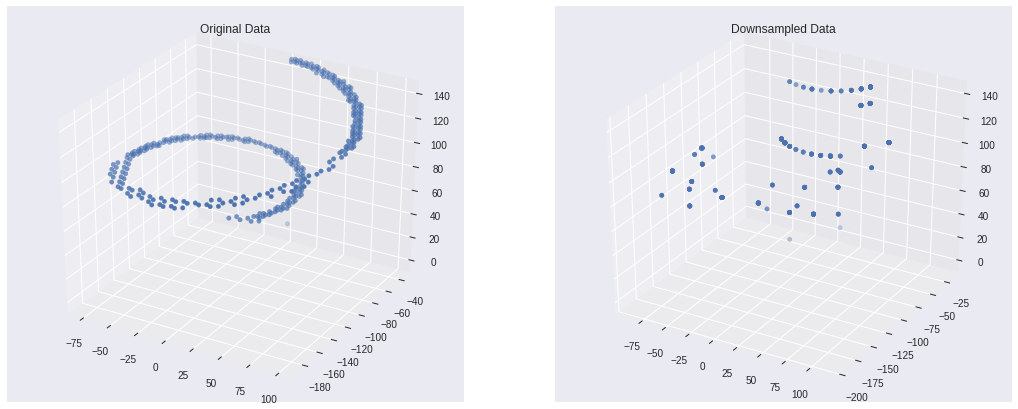

In [15]:
fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(new_xyz[:,0], new_xyz[:,1], new_xyz[:,2])
ax.axis('equal')
ax.set_title("Original Data")

####################################################################################################################
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(discretized_xyz[:,0], discretized_xyz[:,1], discretized_xyz[:,2])
ax.axis('equal')
ax.set_title('Downsampled Data')